### The Model

The linear model of the behavior of drivers satisfies these experimental observations:  
1.  All drivers will approach a maximum velocity $u_{max}$ when the road is empty.
2.  If the road is completely jampacked ($\rho \rightarrow \rho_{max}$), velocity goes to zero.  

That seems like a reasonable approximation of reality! 

Applying a conservation law to the vehicle traffic, the traffic density will obey the following transport equation:

$$
\begin{equation}
\frac{\partial \rho}{\partial t} + \frac{\partial F}{\partial x} = 0
\end{equation}
$$

where $F$ is the *traffic flux*, which in the linear traffic-speed model is given by: 

$$
\begin{equation}
F = \rho u_{\rm max} \left(1-\frac{\rho}{\rho_{\rm max}}\right)
\end{equation}
$$


### Initial Condition: Red Light
In the context of the traffic-flow model of the previous notebook, imagine a very busy road and a red light at $x=4$. Cars accumulate quickly in the front, where we have the maximum allowed density of cars between $x=3$ and $x=4$, and there is an incoming traffic of 50% the maximum allowed density $(\rho = 0.5\rho_{\rm max})$. 

Mathematically, this is:

$$
\begin{equation}
\rho(x,0) = \left\{
\begin{array}{cc}
0.5 \rho_{\rm max} & 0 \leq x < 3  \\
\rho_{\rm max} & 3 \leq x \leq 4 \\
\end{array}
\right.
\end{equation}
$$

Let's find out what the initial condition looks like.

In [1]:
import numpy
from matplotlib import pyplot
%matplotlib inline

In [2]:
# Set the font family and size to use for Matplotlib figures.
pyplot.rcParams['font.family'] = 'serif'
pyplot.rcParams['font.size'] = 16

In [3]:
def rho_red_light(x, rho_max):
    """
    Computes the "red light" initial condition with shock.
    
    Parameters
    ----------
    x : numpy.ndaray
        Locations on the road as a 1D array of floats.
    rho_max : float
        The maximum traffic density allowed.
    
    Returns
    -------
    rho : numpy.ndarray
        The initial car density along the road
        as a 1D array of floats.
    """
    rho = rho_max * numpy.ones_like(x)
    mask = numpy.where(x < 3.0)
    rho[mask] = 0.5 * rho_max
    return rho

### Setting parameters and initial condition

In [4]:
# Set parameters.
nx = 81  # number of locations on the road
L = 4.0  # length of the road
dx = L / (nx - 1)  # distance between two consecutive locations
nt = 40  # number of time steps to compute
rho_max = 10.0  # maximum taffic density allowed
u_max = 1.0  # maximum speed traffic

# Get the road locations.
x = numpy.linspace(0.0, L, num=nx)

# Compute the initial traffic density.
rho0 = rho_red_light(x, rho_max)

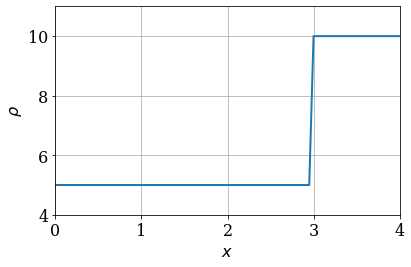

In [5]:
# Plot the initial traffic density.
fig = pyplot.figure(figsize=(6.0, 4.0))
pyplot.xlabel(r'$x$')
pyplot.ylabel(r'$\rho$')
pyplot.grid()
line = pyplot.plot(x, rho0,
                   color='C0', linestyle='-', linewidth=2)[0]
pyplot.xlim(0.0, L)
pyplot.ylim(4.0, 11.0)
pyplot.tight_layout()

### Anticipated Exact Solution 

Before we do any coding, let's think about the equation a little bit. The wave speed $u_{\rm wave}$ is $-1$ for $\rho = \rho_{\rm max}$ and $\rho \leq \rho_{\rm max}/2$, making all velocities negative. We should see a solution moving left, maintaining the shock geometry.

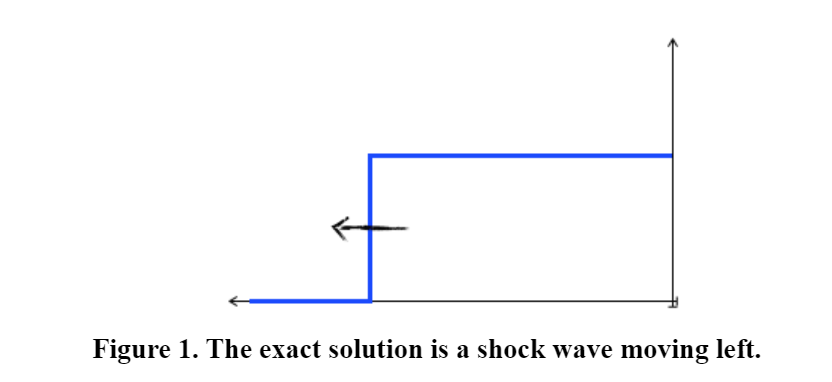

### Defining some useful functions

In [6]:
def flux(rho, u_max, rho_max):
    """
    Computes the traffic flux F = V * rho.
    
    Parameters
    ----------
    rho : numpy.ndarray
       Traffic density along the road as a 1D array of floats.
    u_max : float
        Maximum speed allowed on the road.
    rho_max : float
        Maximum car density allowed on the road.
    
    Returns
    -------
    F : numpy.ndarray
        The traffic flux along the road as a 1D array of floats.
    """
    F = rho * u_max * (1.0 - rho / rho_max)
    return F

In [7]:
from matplotlib import animation
from IPython.display import HTML

In [8]:
def update_plot(n, rho_hist):
    """
    Update the line y-data of the Matplotlib figure.
    
    Parameters
    ----------
    n : integer
        The time-step index.
    rho_hist : list of numpy.ndarray objects
        The history of the numerical solution.
    """
    fig.suptitle('Time step {:0>2}'.format(n))
    line.set_ydata(rho_hist[n])

## FTCS (Forward time, central scheme) Scheme (Unstable)

$$
\begin{equation}
\frac{\partial \rho}{\partial t}\approx \frac{1}{\Delta t}( \rho_i^{n+1}-\rho_i^n )
\end{equation}
$$


$$
\begin{equation}
\frac{\partial F}{\partial x} \approx \frac{1}{2\Delta x}( F_{i+1}-F_{i-1})
\end{equation}
$$
Finally,
$$
\begin{equation}
\rho_i^{n+1} = \rho_i^{n} - \frac{{\Delta t}({F^n_{i+1} - F^n_{i-1}})}{2\Delta x}
\end{equation}
$$

In [9]:
def ftcs(rho0, nt, dt, dx, bc_values, *args):
    
    """
    Compute the traffic density using the FCTS scheme.
    
    Parameters
    --------
    rho0: numpy.ndarray
        the initial condition of the traffic flow as 1D array of floats
    nt: int, number of time steps
    dt: float, time step
    dx: float, spatial step
    bc_values: 2-tuple of floats, Values at boundaries, at first and last location
    args: list or tuple
        Positional arguments for the flux function.
        
    Returns
    -------
    rho_hist: list of numpy.ndarray objects
        Stores the rho values at each location and each time step. 
    """
    
    rho_hist = [rho0.copy()] #enter initial condition as fist element of rho_hist list
    rho = rho0.copy()
    for n in range(nt):
        #Compute Flux
        F = flux(rho, *args)
        #FCTS
        rho[1:-1] = rho[1:-1] - ((0.5*(dt/dx))*(F[2:]-F[:-2]))
        #Set value at first location
        rho[0] = bc_values[0]
        #Set the value at the last location
        rho[-1] = bc_values[1]
        #Record the time-step values
        rho_hist.append(rho.copy())
    return rho_hist
    

In [10]:
#Setting CFL limit 
sigma = 1.0
dt = sigma*dx/u_max 

#Compute the traffic density at all time steps
rho_hist = ftcs(rho0, nt, dt, dx, (rho0[0], rho0[-1]), u_max, rho_max)
#print(rho_hist)

<ipython-input-6-54e89294e156>:19: RuntimeWarning: overflow encountered in multiply
  F = rho * u_max * (1.0 - rho / rho_max)
<ipython-input-9-9d871189eacd>:29: RuntimeWarning: invalid value encountered in subtract
  rho[1:-1] = rho[1:-1] - ((0.5*(dt/dx))*(F[2:]-F[:-2]))


In [11]:
# Create an animation of the traffic density.
anim = animation.FuncAnimation(fig, update_plot,
                               frames=nt, fargs=(rho_hist,),
                               interval=100)
# Display the video.
HTML(anim.to_html5_video())

The animation and the error 'Invalid value encoutered in add', both show that the solution has blown up and is unstable. 

## Lax-Friedrichs scheme (1954)
The idea was to replace the solution value at $\rho^n_i$ by the average of the values at the neighboring grid points. If we do that replacement, we get the following discretized equation: 

$$
\begin{equation}
\frac{\rho_i^{n+1}-\frac{1}{2}(\rho^n_{i+1}+\rho^n_{i-1})}{\Delta t} = -\frac{F^n_{i+1}-F^n_{i-1}}{2 \Delta x}
\end{equation}
$$

The difference between the FTCS and Lax-Friedrichs scheme can be seen from the following stencils: 

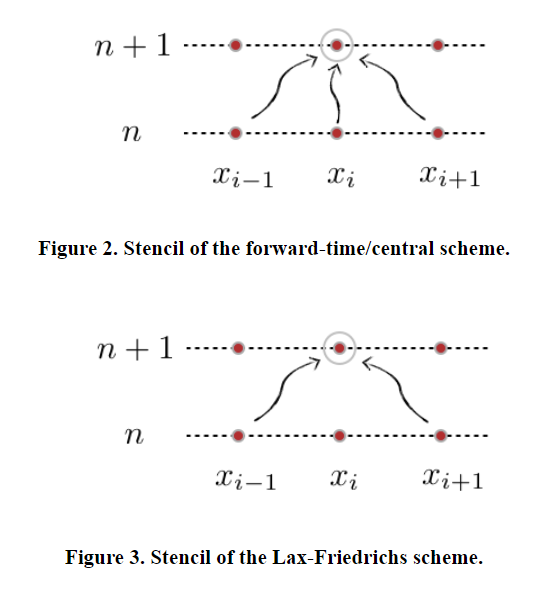

So the final schemen to be implemented is:

$$
\begin{equation}
\rho_i^{n+1} = \frac{1}{2}(\rho^n_{i+1}+\rho^n_{i-1}) - \frac{\Delta t}{2 \Delta x}(F^n_{i+1}-F^n_{i-1})
\end{equation}
$$

In order to display animations, we're going to hold the results of each time step in the variable `rho`, a 2D array.  The resulting array `rho_n` has `nt` rows and `nx` columns.

In [12]:
def lax_friedrichs(rho0, nt, dt, dx, bc_values, *args):
    """
    Computes the traffic density on the road 
    at a certain time given the initial traffic density.
    Integration using Lax-Friedrichs scheme.
    
    Parameters
    ----------
    rho0 : numpy.ndarray
        The initial traffic density along the road
        as a 1D array of floats.
    nt : integer
        The number of time steps to compute.
    dt : float
        The time-step size to integrate.
    dx : float
        The distance between two consecutive locations.
    bc_values : 2-tuple of floats
        The value of the density at the first and last locations.
    args : list or tuple
        Positional arguments to be passed to the flux function.
    
    Returns
    -------
    rho_hist : list of numpy.ndarray objects
        The history of the car density along the road.
    """
    rho_hist = [rho0.copy()]
    rho = rho0.copy()
    for n in range(nt):
        # Compute the flux.
        F = flux(rho, *args)
        # Advance in time using Lax-Friedrichs scheme.
        rho[1:-1] = (0.5 * (rho[:-2] + rho[2:]) -
                     dt / (2.0 * dx) * (F[2:] - F[:-2]))
        # Set the value at the first location.
        rho[0] = bc_values[0]
        # Set the value at the last location.
        rho[-1] = bc_values[1]
        # Record the time-step solution.
        rho_hist.append(rho.copy())
    return rho_hist

In [13]:
def dt_generator(sigma, dx, u_max):
    """
    Parameters:

    sigma = float, the CFL number limit
    dx = float, delta x
    u_max = float, the maximum permissible velocity of wave
    -----------
    Returns: 
    
    dt = float, the time-step value
    -----------
    """
    dt = sigma*dx/u_max
    
    return dt

In [14]:
# Set the time-step size based on CFL limit.
#sigma = 1.0
#dt = sigma * dx / u_max  # time-step size
dt_1 = dt_generator(1.0, dx, u_max)
# Compute the traffic density at all time steps.
rho_hist = lax_friedrichs(rho0, nt, dt_1, dx, (rho0[0], rho0[-1]),
                          u_max, rho_max)

In [15]:
# Create an animation of the traffic density.
anim = animation.FuncAnimation(fig, update_plot,
                               frames=nt, fargs=(rho_hist,),
                               interval=100)
# Display the video.
HTML(anim.to_html5_video())

The staircase behaviour of the leading edge of the wave is due to the **odd-even decoupling** phenomena. Find more about it here: https://nbviewer.jupyter.org/github/barbagroup/CFDPython/blob/14b56718ac1508671de66bab3fe432e93cb59fcb/lessons/19_Odd_Even_Decoupling.ipynb

In [16]:
#with sigma = 0.5
#a lower sigma means a smaller time-step, thus expecting better accuracy. 

dt_2 = dt_generator(0.5, dx, u_max)
rho_hist = lax_friedrichs(rho0, nt, dt_2, dx, (rho0[0], rho0[-1]),
                          u_max, rho_max)

In [17]:
# Create an animation of the traffic density.
anim = animation.FuncAnimation(fig, update_plot,
                               frames=nt, fargs=(rho_hist,),
                               interval=100)
# Display the video.
HTML(anim.to_html5_video())

## Lax-Wendroff scheme (1960) [Jacobian based]

Find the derivation of the Lax-Wendroff scheme in the notes and the jupyter notebook

\begin{align}
&\rho_i^{n+1} = \rho_i^n - \frac{\Delta t}{2 \Delta x} \left(F^n_{i+1}-F^n_{i-1}\right) + \cdots \\ \nonumber 
&+ \frac{(\Delta t)^2}{4(\Delta x)^2} \left[ (J^n_{i+1}+J^n_i)(F^n_{i+1}-F^n_i)-(J^n_i+J^n_{i-1})(F^n_i-F^n_{i-1})\right]
\end{align}

with

\begin{equation}J^n_i = \frac{\partial F}{\partial \rho} = u_{\rm max} \left(1-2\frac{\rho^n_i}{\rho_{\rm max}} \right).\end{equation} 

Lax-Wendroff is a little bit long.  Remember that you can use \ slashes to split up a statement across several lines.  This can help make code easier to parse (and also easier to debug!). 

In [18]:
def jacobian(rho, u_max, rho_max):
    """
    Computes the Jacobian for our traffic model.
    
    Parameters
    ----------
    rho : numpy.ndarray
       Traffic density along the road as a 1D array of floats.
    u_max : float
        Maximum speed allowed on the road.
    rho_max : float
        Maximum car density allowed on the road.
    
    Returns
    -------
    J : numpy.ndarray
        The Jacobian as a 1D array of floats.
    """
    J = u_max * (1.0 - 2.0 * rho / rho_max)
    return J


In [19]:
def lax_wendroff(rho0, nt, dt, dx, bc_values, *args):
    """
    Computes the traffic density on the road 
    at a certain time given the initial traffic density.
    Integration using Lax-Wendroff scheme.
    
    Parameters
    ----------
    rho0 : numpy.ndarray
        The initial traffic density along the road
        as a 1D array of floats.
    nt : integer
        The number of time steps to compute.
    dt : float
        The time-step size to integrate.
    dx : float
        The distance between two consecutive locations.
    bc_values : 2-tuple of floats
        The value of the density at the first and last locations.
    args : list or tuple
        Positional arguments to be passed to the
        flux and Jacobien functions.
    
    Returns
    -------
    rho_hist : list of numpy.ndarray objects
        The history of the car density along the road.
    """
    rho_hist = [rho0.copy()]
    rho = rho0.copy()
    for n in range(nt):
        # Compute the flux.
        F = flux(rho, *args)
        # Compute the Jacobian.
        J = jacobian(rho, *args)
        # Advance in time using Lax-Wendroff scheme.
        rho[1:-1] = (rho[1:-1] -
                     dt / (2.0 * dx) * (F[2:] - F[:-2]) +
                     dt**2 / (4.0 * dx**2) *
                     ((J[1:-1] + J[2:]) * (F[2:] - F[1:-1]) -
                      (J[:-2] + J[1:-1]) * (F[1:-1] - F[:-2])))
        # Set the value at the first location.
        rho[0] = bc_values[0]
        # Set the value at the last location.
        rho[-1] = bc_values[1]
        # Record the time-step solution.
        rho_hist.append(rho.copy())
    return rho_hist

In [20]:
#Lax wendroff with sigma 1.0

rho_hist = lax_wendroff(rho0, nt, dt_1, dx, (rho0[0], rho0[-1]),
                        u_max, rho_max)

# Create an animation of the traffic density.
anim = animation.FuncAnimation(fig, update_plot,
                               frames=nt, fargs=(rho_hist,),
                               interval=100)
# Display the video.
HTML(anim.to_html5_video())

In [21]:
#Lax wendroff with sigma 0.5

rho_hist = lax_wendroff(rho0, nt, dt_2, dx, (rho0[0], rho0[-1]),
                        u_max, rho_max)

# Create an animation of the traffic density.
anim = animation.FuncAnimation(fig, update_plot,
                               frames=nt, fargs=(rho_hist,),
                               interval=100)
# Display the video.
HTML(anim.to_html5_video())

## MacCormack Scheme (1971)

The MacCormack scheme is a two-step method, in which the first step is called a _predictor_ and the second step is called a _corrector_. It achieves second-order accuracy in both space and time. One version is as follows:  

$$
\begin{equation}
\rho^*_i = \rho^n_i - \frac{\Delta t}{\Delta x} (F^n_{i+1}-F^n_{i}) \ \ \ \ \ \ \text{(predictor with fwd spatial diff)}
\end{equation}
$$

$$
\begin{equation}
\rho^{n+1}_i = \frac{1}{2} (\rho^n_i + \rho^*_i - \frac{\Delta t}{\Delta x} (F^*_i - F^{*}_{i-1})) \ \ \ \ \ \ \text{(corrector with backward spatial diff)}
\end{equation}
$$

If you look closely, it appears like the first step is a forward-time/forward-space scheme, and the second step is like a forward-time/backward-space scheme (these can also be reversed), averaged with the first result. What is so cool about this? You can compute problems with left-running waves and right-running waves, and the MacCormack scheme gives you a stable method (subject to the CFL condition). Nice! Let's try it.

In [22]:
def maccormack(rho0, nt, dt, dx, bc_values, *args):
    """
    Computes the traffic density on the road 
    at a certain time given the initial traffic density.
    Integration using MacCormack scheme.
    
    Parameters
    ----------
    rho0 : numpy.ndarray
        The initial traffic density along the road
        as a 1D array of floats.
    nt : integer
        The number of time steps to compute.
    dt : float
        The time-step size to integrate.
    dx : float
        The distance between two consecutive locations.
    bc_values : 2-tuple of floats
        The value of the density at the first and last locations.
    args : list or tuple
        Positional arguments to be passed to the flux function.
    
    Returns
    -------
    rho_hist : list of numpy.ndarray objects
        The history of the car density along the road.
    """
    rho_hist = [rho0.copy()]
    rho = rho0.copy()
    rho_star = rho.copy()
    for n in range(nt):
        # Compute the flux.
        F = flux(rho, *args)
        # Predictor step of the MacCormack scheme.
        rho_star[1:-1] = (rho[1:-1] -
                          dt / dx * (F[2:] - F[1:-1]))
        # Compute the flux.
        F = flux(rho_star, *args)
        # Corrector step of the MacCormack scheme.
        rho[1:-1] = 0.5 * (rho[1:-1] + rho_star[1:-1] -
                           dt / dx * (F[1:-1] - F[:-2]))
        # Set the value at the first location.
        rho[0] = bc_values[0]
        # Set the value at the last location.
        rho[-1] = bc_values[1]
        # Record the time-step solution.
        rho_hist.append(rho.copy())
    return rho_hist

In [23]:
# Set the time-step size based on CFL limit.

rho_hist = maccormack(rho0, nt, dt_1, dx, (rho0[0], rho0[-1]),
                      u_max, rho_max)

# Create an animation of the traffic density.
anim = animation.FuncAnimation(fig, update_plot,
                               frames=nt, fargs=(rho_hist,),
                               interval=100)
# Display the video.
HTML(anim.to_html5_video())

In [24]:
#With sigma 0.5
rho_hist = maccormack(rho0, nt, dt_2, dx, (rho0[0], rho0[-1]),
                      u_max, rho_max)

# Create an animation of the traffic density.
anim = animation.FuncAnimation(fig, update_plot,
                               frames=nt, fargs=(rho_hist,),
                               interval=100)
# Display the video.
HTML(anim.to_html5_video())

You can also obtain a MacCormack scheme by reversing the predictor and corrector steps. For shocks, the best resolution will occur when the difference in the predictor step is in the direction of propagation. Try it out! Was our choice here the ideal one? In which case is the shock better resolved?

$$
\begin{equation}
\rho^*_i = \rho^n_i - \frac{\Delta t}{\Delta x} (F^n_{i}-F^n_{i-1}) \ \ \ \ \ \ \text{(predictor with backward spatial diff)}
\end{equation}
$$

$$
\begin{equation}
\rho^{n+1}_i = \frac{1}{2} (\rho^n_i + \rho^*_i - \frac{\Delta t}{\Delta x} (F^*_{i+1} - F^{*}_{i})) \ \ \ \ \ \ \text{(corrector with forward spatial diff)}
\end{equation}
$$

In [25]:
def maccormack_bwd_fwd(rho0, nt, dt, dx, bc_values, *args):
    """
    Computes the traffic density on the road 
    at a certain time given the initial traffic density.
    Integration using MacCormack scheme with predictor step in backward diff
    
    Parameters
    ----------
    rho0 : numpy.ndarray
        The initial traffic density along the road
        as a 1D array of floats.
    nt : integer
        The number of time steps to compute.
    dt : float
        The time-step size to integrate.
    dx : float
        The distance between two consecutive locations.
    bc_values : 2-tuple of floats
        The value of the density at the first and last locations.
    args : list or tuple
        Positional arguments to be passed to the flux function.
    
    Returns
    -------
    rho_hist : list of numpy.ndarray objects
        The history of the car density along the road.
    """
    rho_hist = [rho0.copy()]
    rho = rho0.copy()
    rho_star = rho.copy()
    for n in range(nt):
        # Compute the flux.
        F = flux(rho, *args)
        # Predictor step of the MacCormack scheme.
        rho_star[1:-1] = (rho[1:-1] -
                          dt / dx * (F[1:-1] - F[:-2]))
        # Compute the flux.
        F = flux(rho_star, *args)
        # Corrector step of the MacCormack scheme.
        rho[1:-1] = 0.5 * (rho[1:-1] + rho_star[1:-1] -
                           dt / dx * (F[2:] - F[1:-1]))
        # Set the value at the first location.
        rho[0] = bc_values[0]
        # Set the value at the last location.
        rho[-1] = bc_values[1]
        # Record the time-step solution.
        rho_hist.append(rho.copy())
    return rho_hist

In [26]:
# Set the time-step size based on CFL limit.

rho_hist = maccormack_bwd_fwd(rho0, nt, dt_1, dx, (rho0[0], rho0[-1]),
                      u_max, rho_max)

# Create an animation of the traffic density.
anim = animation.FuncAnimation(fig, update_plot,
                               frames=nt, fargs=(rho_hist,),
                               interval=100)
# Display the video.
HTML(anim.to_html5_video())

It can be observed that with the backward predictor step, the shock in the traffic flow model considered here can be resolved properly w/o any numerical oscillations. 

## Challenge Task

In the *red light* problem, $\rho \geq \rho_{\rm max}/2$, making the wave speed negative at all points . You might be wondering why we introduced these new methods; couldn't we have just used a forward-time/forward-space scheme? But, what if $\rho_{\rm in} < \rho_{\rm max}/2$? Now, a whole region has negative wave speeds and forward-time/backward-space is unstable. 

* How do Lax-Friedrichs, Lax-Wendroff and MacCormack behave in this case? Try it out!

* As you decrease $\rho_{\rm in}$, what happens to the velocity of the shock? Why do you think that happens?

In [27]:
def new_rho_red_light(x, k, rho_max):
    """
    Computes the "red light" initial condition with shock.
    
    Parameters
    ----------
    x : numpy.ndaray
        Locations on the road as a 1D array of floats.
    k : float
        A constant to multiply with rho_max for rho @ x<3
    rho_max : float
        The maximum traffic density allowed.
    
    Returns
    -------
    rho : numpy.ndarray
        The initial car density along the road
        as a 1D array of floats.
    """
    rho = rho_max * numpy.ones_like(x)
    mask = numpy.where(x < 3.0)
    rho[mask] = k * rho_max
    return rho

In [28]:
#definting the forward time, backward space scheme function
def ftbs(rho0, nt, dt, dx, bc_value, *args):
    
    rho_hist = [rho0.copy()]
    rho = rho0.copy() #initialize @ t=0
    for n in range(nt):
        #Compute Flux
        F = flux(rho, *args)
        #Compute array operation for next time step
        rho[1:] = rho[1:] - dt/dx * (F[1:]-F[:-1])
        # Set the left boundary condition.
        rho[0] = bc_value[0]
        #print(bc_value)
        # Record the time-step solution.
        rho_hist.append(rho.copy())
    return rho_hist

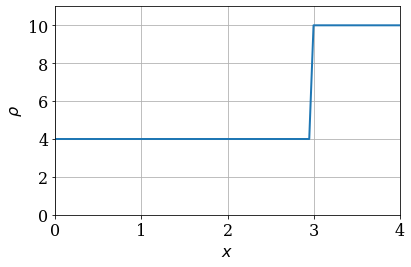

In [29]:
# Compute the initial traffic density.
rho0 = new_rho_red_light(x, 0.4, rho_max)

# Plot the initial traffic density.
fig = pyplot.figure(figsize=(6.0, 4.0))
pyplot.xlabel(r'$x$')
pyplot.ylabel(r'$\rho$')
pyplot.grid()
line = pyplot.plot(x, rho0,
                   color='C0', linestyle='-', linewidth=2)[0]
pyplot.xlim(0.0, L)
pyplot.ylim(0.0, 11.0)
pyplot.tight_layout()

In [30]:
# With FTBS scheme at sigma = 1.0

rho_hist = ftbs(rho0, nt, dt_1, dx, (rho0[0], rho0[-1]),
                          u_max, rho_max)

# Create an animation of the traffic density.
anim = animation.FuncAnimation(fig, update_plot,
                               frames=nt, fargs=(rho_hist,),
                               interval=100)
# Display the video.
HTML(anim.to_html5_video())

<ipython-input-6-54e89294e156>:19: RuntimeWarning: overflow encountered in multiply
  F = rho * u_max * (1.0 - rho / rho_max)
<ipython-input-28-266f92e182a2>:10: RuntimeWarning: invalid value encountered in subtract
  rho[1:] = rho[1:] - dt/dx * (F[1:]-F[:-1])


#### It can be seen that the FTBS scheme is instable for this initial condition

In [31]:
# With Lax-Freidrichs scheme at sigma = 1.0

rho_hist = lax_friedrichs(rho0, nt, dt_1, dx, (rho0[0], rho0[-1]),
                          u_max, rho_max)

# Create an animation of the traffic density.
anim = animation.FuncAnimation(fig, update_plot,
                               frames=nt, fargs=(rho_hist,),
                               interval=100)
# Display the video.
HTML(anim.to_html5_video())

In [32]:
# With Lax-Wendroff scheme at sigma = 1.0

rho_hist = lax_wendroff(rho0, nt, dt_1, dx, (rho0[0], rho0[-1]),
                        u_max, rho_max)

# Create an animation of the traffic density.
anim = animation.FuncAnimation(fig, update_plot,
                               frames=nt, fargs=(rho_hist,),
                               interval=100)
# Display the video.
HTML(anim.to_html5_video())

In [33]:
# With MacCormack (fwd predcitor) scheme at sigma = 1.0

rho_hist = maccormack(rho0, nt, dt_1, dx, (rho0[0], rho0[-1]),
                      u_max, rho_max)

# Create an animation of the traffic density.
anim = animation.FuncAnimation(fig, update_plot,
                               frames=nt, fargs=(rho_hist,),
                               interval=100)
# Display the video.
HTML(anim.to_html5_video())

In [34]:
# With MacCormack (bckwd predcitor) scheme at sigma = 1.0

rho_hist = maccormack_bwd_fwd(rho0, nt, dt_1, dx, (rho0[0], rho0[-1]),
                      u_max, rho_max)

# Create an animation of the traffic density.
anim = animation.FuncAnimation(fig, update_plot,
                               frames=nt, fargs=(rho_hist,),
                               interval=100)
# Display the video.
HTML(anim.to_html5_video())

Lets try to see the effect of decreasing $\rho_{\rm in}$ on the velocity of the shock, and understand why that happens. 

In [35]:
rho0_1 = new_rho_red_light(x, 0.4, rho_max) 

# With MacCormack (bckwd predcitor) scheme at sigma = 1.0

rho_hist = maccormack_bwd_fwd(rho0_1, nt, dt_1, dx, (rho0_1[0], rho0_1[-1]),
                      u_max, rho_max)

# Create an animation of the traffic density.
anim = animation.FuncAnimation(fig, update_plot,
                               frames=nt, fargs=(rho_hist,),
                               interval=50)
# Display the video.
HTML(anim.to_html5_video())

In [36]:
rho0_2 = new_rho_red_light(x, 0.3, rho_max) 

# With MacCormack (bckwd predcitor) scheme at sigma = 1.0

rho_hist = maccormack_bwd_fwd(rho0_2, nt, dt_1, dx, (rho0_2[0], rho0_2[-1]),
                      u_max, rho_max)

# Create an animation of the traffic density.
anim = animation.FuncAnimation(fig, update_plot,
                               frames=nt, fargs=(rho_hist,),
                               interval=50)
# Display the video.
HTML(anim.to_html5_video())

In [37]:
rho0_3 = new_rho_red_light(x, 0.2, rho_max) 

# With MacCormack (bckwd predcitor) scheme at sigma = 1.0

rho_hist = maccormack_bwd_fwd(rho0_3, nt, dt_1, dx, (rho0_3[0], rho0_3[-1]),
                      u_max, rho_max)

# Create an animation of the traffic density.
anim = animation.FuncAnimation(fig, update_plot,
                               frames=nt, fargs=(rho_hist,),
                               interval=50)
# Display the video.
HTML(anim.to_html5_video())

In [38]:
rho0_4 = new_rho_red_light(x, 0.1, rho_max) 

# With MacCormack (bckwd predcitor) scheme at sigma = 1.0

rho_hist = maccormack_bwd_fwd(rho0_4, nt, dt_1, dx, (rho0_4[0], rho0_4[-1]),
                      u_max, rho_max)

# Create an animation of the traffic density.
anim = animation.FuncAnimation(fig, update_plot,
                               frames=nt, fargs=(rho_hist,),
                               interval=50)
# Display the video.
HTML(anim.to_html5_video())